In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import scipy
import ncc
import PIL.Image

# PART 1

# 2.

In [507]:
def MakeGaussianPyramid(image, minsize,scale = 0.75) :
    dimX = image.size[0]
    dimY = image.size[1]
    pyramid =  [image]    
    #RGB -3d
    
    #nonRGB -2d
    
    while (dimX * scale >= minsize) and (dimY * scale >= minsize):
        dimX = int(dimX*scale)
        dimY = int(dimY*scale)
        tempImg = np.asarray(image)
        
        if len(tempImg.shape) ==2: # to determine if image has rgb channel    
            # 1. apply gaussian filter
            tempImg = scipy.ndimage.gaussian_filter(tempImg, sigma=1 / (2 * scale))
            # 2. resize
            tempImg = PIL.Image.fromarray(tempImg)
        
        else :
            b, g, r  = tempImg[:, :, 0], tempImg[:, :, 1], tempImg[:, :, 2]
            sigma = 1 / (2 * scale)
            b = scipy.ndimage.gaussian_filter(b, sigma)
            g = scipy.ndimage.gaussian_filter(g, sigma)
            r = scipy.ndimage.gaussian_filter(r, sigma)
            zipped = np.dstack((b, g, r))
            zipped = zipped.astype('uint8')
            tempImg = PIL.Image.fromarray(zipped)
        
        tempImg = tempImg.resize((dimX,dimY),Image.BICUBIC)
        # 3. add to pyramidß
        pyramid.append(tempImg)
    
    return pyramid

In [508]:
image_judybats = PIL.Image.open("judybats.jpg")
minsize = 15
pyramid_judybats = MakeGaussianPyramid(image_judybats,minsize) 

# 3.

In [482]:
def ShowGaussianPyramid(pyramid):
    # 1. creating a blank image of the right size
    length = len(pyramid)
    # get the size of the big image
    width  = sum(img.size[0] for img in pyramid)
    height = pyramid[0].size[1]
    tempImg = PIL.Image.new("RGB", (width, height),"white")
    # 2. pasting existing images into it 
    offset_x = 0
    for i in range(length):
        tempMat = np.asarray(pyramid[i])
        offset_y = pyramid[0].size[1]-pyramid[i].size[1]
        tempImg.paste(pyramid[i],(offset_x,offset_y))
        offset_x += pyramid[i].size[0]
    # 3. initialize unused space with white (rather than black)
    return tempImg

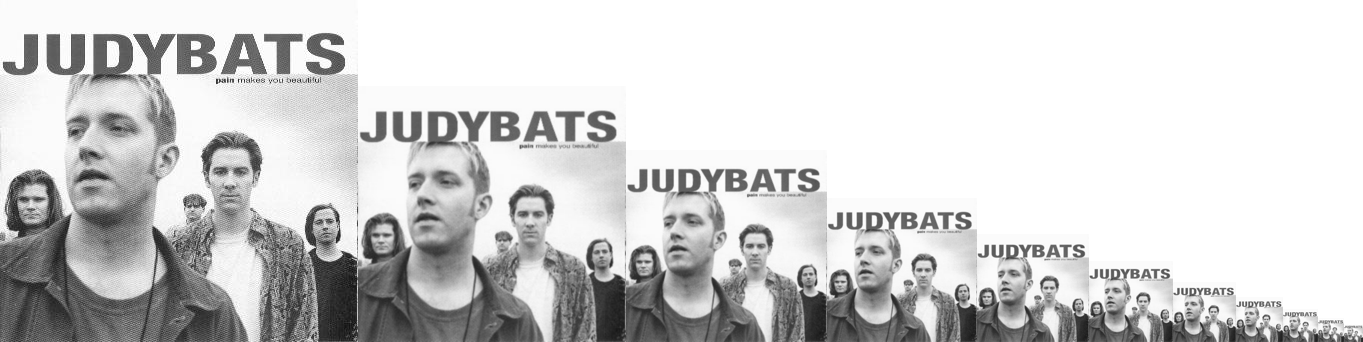

In [500]:
showPyramid_jubybats = ShowGaussianPyramid(pyramid_judybats)
display(showPyramid_jubybats)

# 4.

In [270]:
def FindTemplate(pyramid, template, threshold):
    # 1. resize the template
    #Reduce the width to 15 pixels, proportionally scaling the height 
    #so the aspect ratio is maintained with scaling, using imresize with bicubic interpolation. 
    wTem = 15 
    hTem  = int(template.size[1] / (template.size[0]/wTem))
    template = template.resize((wTem,hTem),Image.BICUBIC)
    # 2. Call NCC
    retCorr = []
    for img in pyramid:
        ret = ncc.normxcorr2D(img, template)# The returned array is the same size as image
        retCorr.append(ret)
    # 3. For each pixel at which the normalized correlation result is above the threshold, 
    # draw lines (forming a rectangle) to mark the boundary of the template at that location.
    
    #lines should be shown overlayed on the original image (the first image in the pyramid),
    #which means that template matches at other scales will need to be adjusted by the right scale factor
    #(i.e., by the right power of 0.75).
    target = pyramid[0]
    target = target.convert('RGB')
    s = 0
    for cor in retCorr:
        for y in range(cor.shape[0]):
            for x in range(cor.shape[1]):
                if cor[y,x] > threshold:
                    draw = ImageDraw.Draw(target)
                    
                    #up
                    x1 = (x - (wTem / 2))/(0.75 ** s)
                    x2 = (x + (wTem / 2))/(0.75 ** s)
                    y1 = (y + (hTem/2)) / (0.75 ** s)
                    y2 = (y + (hTem/2)) / (0.75 ** s)
                    draw.line((x1,y1,x2,y2),fill="red",width=2)
                    #left
                    x1 = (x - (wTem / 2))/(0.75 ** s)
                    x2 = (x - (wTem / 2))/(0.75 ** s)
                    y1 = (y - (hTem/2)) / (0.75 ** s)
                    y2 = (y + (hTem/2)) / (0.75 ** s)
                    draw.line((x1,y1,x2,y2),fill="red",width=2)
                    #right
                    x1 = (x + (wTem / 2))/(0.75 ** s)
                    x2 = (x + (wTem / 2))/(0.75 ** s)
                    y1 = (y - (hTem/2)) / (0.75 ** s)
                    y2 = (y + (hTem/2)) / (0.75 ** s)
                    draw.line((x1,y1,x2,y2),fill="red",width=2)
                    #bottom
                    x1 = (x - (wTem / 2))/(0.75 ** s)
                    x2 = (x + (wTem / 2))/(0.75 ** s)
                    y1 = (y - (hTem/2)) / (0.75 ** s)
                    y2 = (y - (hTem/2)) / (0.75 ** s)
                    draw.line((x1,y1,x2,y2),fill="red",width=2)
                    
                    del draw
        s += 1
    
    return target
    
    

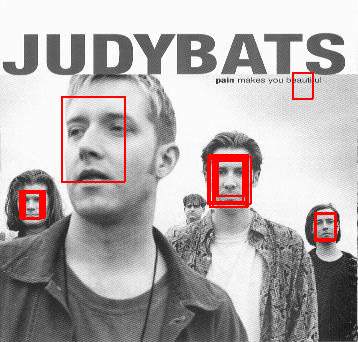

In [281]:
image_template = PIL.Image.open("template.jpg")
retJuby = FindTemplate(pyramid_judybats, image_template, 0.63)
retJuby

# 5.

 # As tried out in the judybats image, the final threshold is 0.63

In [501]:
# 5 TEST CASES 
image_family = PIL.Image.open("family.jpg")
image_fans = PIL.Image.open("fans.jpg")
image_trees = PIL.Image.open("tree.jpg")
image_sport = PIL.Image.open("sports.jpg")
image_student = PIL.Image.open("students.jpg")

pyramid_family = MakeGaussianPyramid(image_family,minsize) 
pyramid_fans = MakeGaussianPyramid(image_fans,minsize) 
pyramid_trees = MakeGaussianPyramid(image_trees,minsize) 
pyramid_sport = MakeGaussianPyramid(image_sport,minsize) 
pyramid_student = MakeGaussianPyramid(image_student,minsize) 


retfamily = FindTemplate(pyramid_family, image_template, 0.63)
retfans = FindTemplate(pyramid_fans, image_template, 0.63)
rettrees = FindTemplate(pyramid_trees, image_template, 0.63)
retsport = FindTemplate(pyramid_sport, image_template, 0.63)
retstudent = FindTemplate(pyramid_student, image_template, 0.63)



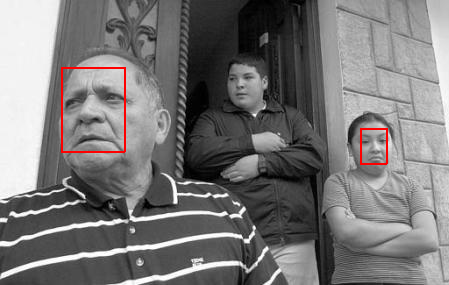

In [283]:
display(retfamily)

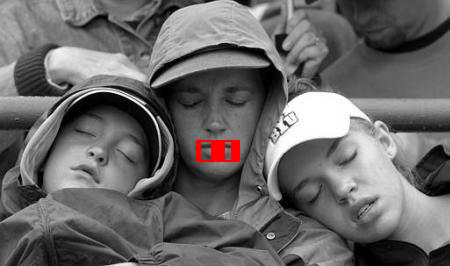

In [284]:
display(retfans)

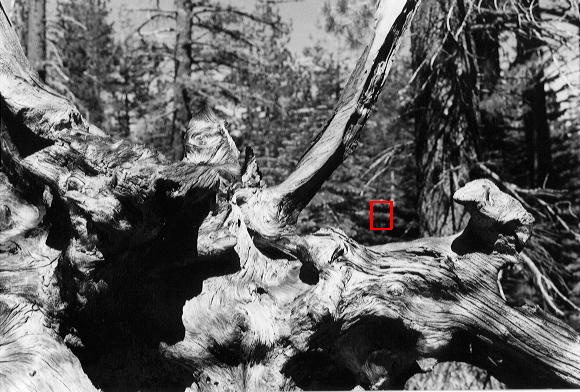

In [285]:
display(rettrees)

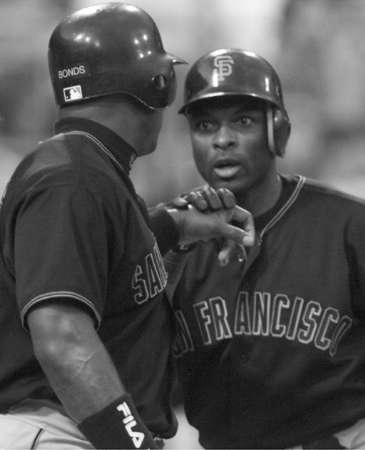

In [286]:
display(retsport)

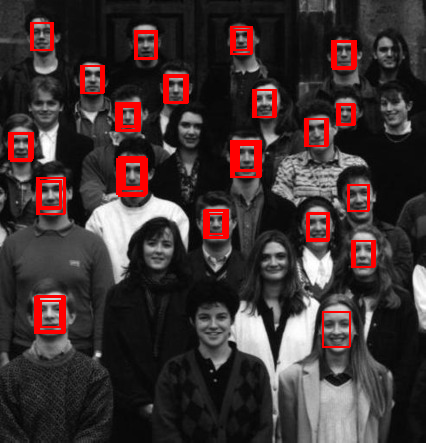

In [287]:
display(retstudent)

# 6.

The recall rate of 

$judybats = 4/5$

$family = 1$

$trees = 0$

$fans = 0$

$sport = 0$

$student = 20/27$

The reason why NCC does not have a good recall rate on some images is that the lighting on the faces from these images affects the result after selecting thresholder. For example, in the image of the fans, only the lips are in the lighter part, so for the selected threshold we only have the wrongly recognized lips part.

Also, the facial experion for different images varies as well. For example, in the sport image, the men facing towards us opens his mouth while the template's face having closed lips. That's another reason why the recall rate is low.

# Part 2

# 2.

In [640]:
image_orchid = PIL.Image.open("orchid.jpg")
image_violet = PIL.Image.open("violet.jpg")

def MakeLaplacianPyramid(image, minsize, scale = 0.75):
    # pyramid should be represented as a list of 3d numpy arrays
    # the first two dimensions correspond to resplution at the given level and
    # the last dimension is 3, corresponding to color channels.
    
    # stop when any further reduction in size will make the larger of 
    #  the spatial dimensions of the image smaller than minsize
    
    # 1. use Gaussian pyramid 
    pyramidG = MakeGaussianPyramid(image, minsize,scale = 0.75)
    pyramid = []
    # 2. taking differences of Gaussian pyramid levels and their smoothed variants.
    for i in range(0,len(pyramidG) - 1):
        currImg = np.asarray(pyramidG[i])
        nextImg = pyramidG[i+1]
        nextImg = nextImg.resize((pyramidG[i].size[0],pyramidG[i].size[1]),Image.BICUBIC)
        nextImg = np.asarray(nextImg)
        b1, g1, r1  = currImg[:, :, 0], currImg[:, :, 1], currImg[:, :, 2]
        b2, g2, r2  = currImg[:, :, 0], nextImg[:, :, 1], nextImg[:, :, 2]
        
        retB = np.subtract(b1,b2)
        retG = np.subtract(g1,g2)
        retR = np.subtract(r1,r2)
        
        zipped = np.dstack((retB, retG, retR))
        zipped = zipped.astype('uint8')
        tempImg = PIL.Image.fromarray(zipped)
        
        pyramid.append(tempImg)
    
    pyramid.append(pyramidG[len(pyramidG)-1])
    return pyramid

In [680]:
pyramid_orchid = MakeLaplacianPyramid(image_orchid,minsize = 190) 
pyramid_orchid

[<PIL.Image.Image image mode=RGB size=512x341 at 0x7F8CF3857E50>,
 <PIL.Image.Image image mode=RGB size=384x255 at 0x7F8CF384E8E0>,
 <PIL.Image.Image image mode=RGB size=288x191 at 0x7F8CF3857730>]

# 3.

In [628]:
def ShowLaplacianPyramid(pyramid):
#     displaying Laplacyan pyramids as all but the last level will contain values in the range -128 to 128
#     if you are working with image pixels in 0 to 255 range 
#     (or between -0.5 and 0.5 if you normalized the range to 0 to 1)
    retpyramid = []
    print(pyramid[len(pyramid)-1])
    for img in pyramid[:len(pyramid)-1]:
        imgArr = np.asarray(img)
        #add 128
        b, g, r  = imgArr[:, :, 0], imgArr[:, :, 1], imgArr[:, :, 2]
        if (b.all() and g.all() and r.all()):
            imgArr = np.add(imgArr, np.full(imgArr.shape, 0.5))
        else: 
            imgArr = np.add(imgArr, np.full(imgArr.shape, 128))
        imgArr = imgArr.astype('uint8')
        imgArr = PIL.Image.fromarray(imgArr)
        retpyramid.append(imgArr)
        
    retpyramid.append(pyramid[len(pyramid)-1])
    
     # 1. creating a blank image of the right size
    length = len(pyramid)
    # get the size of the big image
    width  = sum(img.size[0] for img in pyramid)
    height = pyramid[0].size[1]
    tempImg = PIL.Image.new("RGB", (width, height),"white")
    # 2. pasting existing images into it 
    offset_x = 0
    for img in retpyramid:
        tempMat = np.asarray(img)
        offset_y = retpyramid[0].size[1]-img.size[1]
        tempImg.paste(img,(offset_x,offset_y))
        offset_x += img.size[0]
    # 3. initialize unused space with white (rather than black)
    return tempImg

<PIL.Image.Image image mode=RGB size=288x191 at 0x7F8CF3857730>


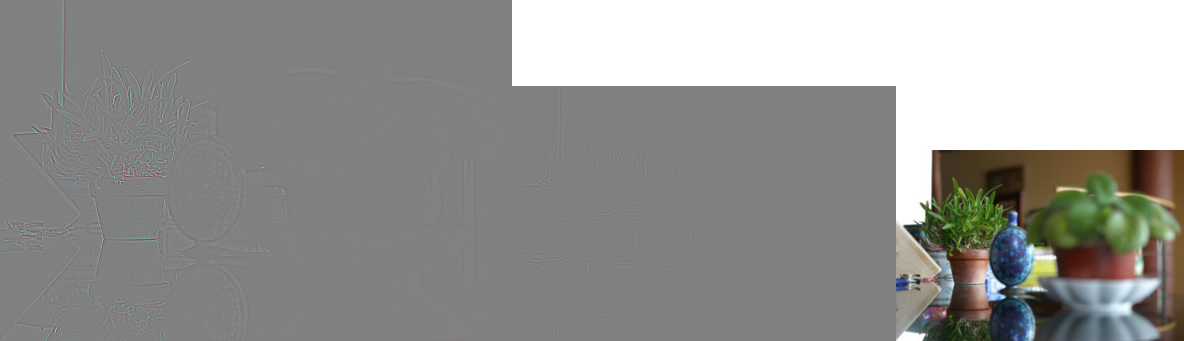

In [683]:
show_orchid = ShowLaplacianPyramid(pyramid_orchid)
display(show_orchid)
show_orchid.save('orchid_L.png')

<PIL.Image.Image image mode=RGB size=288x191 at 0x7F8CF384EE80>


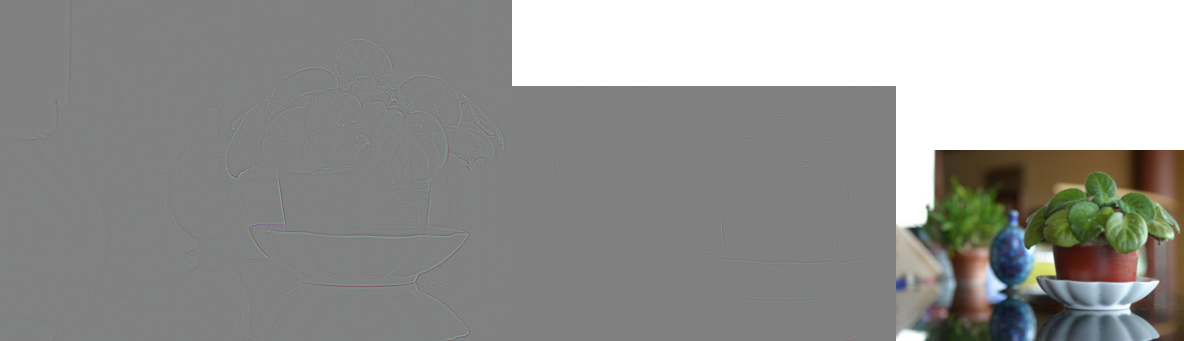

In [684]:
pyramid_violet = MakeLaplacianPyramid(image_violet,minsize = 190) 
show_violet = ShowLaplacianPyramid(pyramid_violet)
display(show_violet)
show_violet.save('violet_L.png')

# 4

In [644]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
    # 1. highest level of the Laplacian pyramid (smallest resolution)
    lPyramid_copy = lPyramid
    reconstructHelper(len(lPyramid)-1, lPyramid_copy)
    return lPyramid_copy
def reconstructHelper(level, lPyramid):
    if level == 0:
        return lPyramid[level]
    else:
        # 2. upsample it to match the resolution of the next level 
        reconstructHelper(level - 1, lPyramid)
        currImg = lPyramid[len(lPyramid) - level]
        prevImg = lPyramid[len(lPyramid) - level -1]
        dimpreX,dimpreY = prevImg.size
        currImg = currImg.resize((dimpreX,dimpreY), Image.BICUBIC)
        
        currImg = np.asarray(currImg)
        prevImg = np.asarray(prevImg)
        
        b1, g1, r1  = currImg[:, :, 0], currImg[:, :, 1], currImg[:, :, 2]
        b2, g2, r2 = prevImg[:,:, 0], prevImg[:,:, 1], prevImg[:,:, 2]
        
        # 3. add that level to the upsampled version to obtain a corresponding Gaussian level
        retb = np.add(b1,b2)
        retg = np.add(g1,g2)
        retr = np.add(r1,r2)
        
        zipped = np.dstack((retb, retg, retr))
        zipped = zipped.astype('uint8')
        retImg = PIL.Image.fromarray(np.clip(zipped, 0, 255))
        lPyramid[len(lPyramid)-level - 1] = retImg


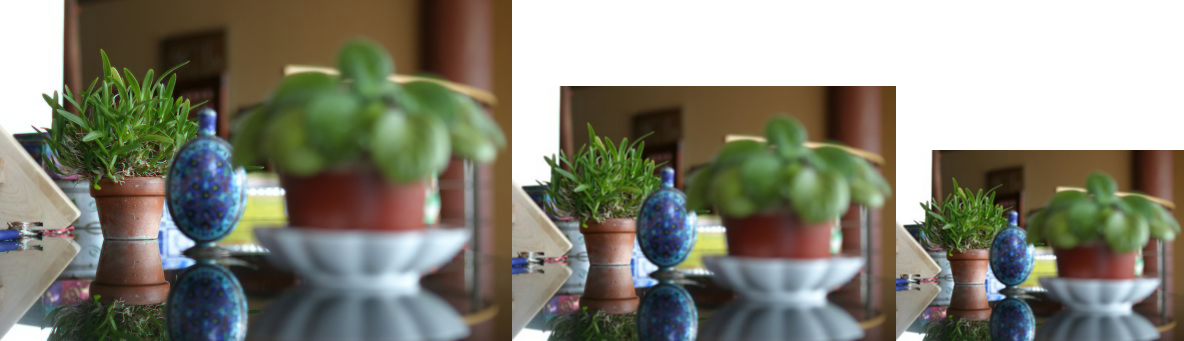

In [685]:
re_orchid = ReconstructGaussianFromLaplacianPyramid(pyramid_orchid)
ShowGaussianPyramid(re_orchid)

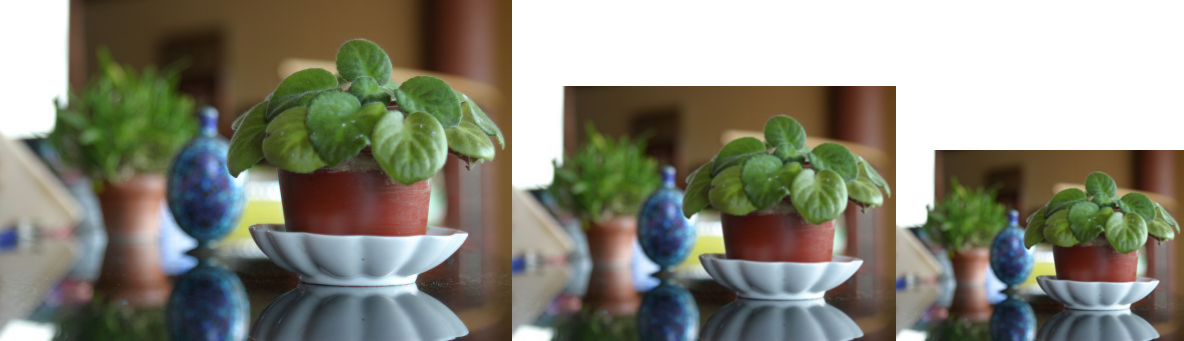

In [686]:
re_violet = ReconstructGaussianFromLaplacianPyramid(pyramid_violet)
ShowGaussianPyramid(re_violet)

# 5.

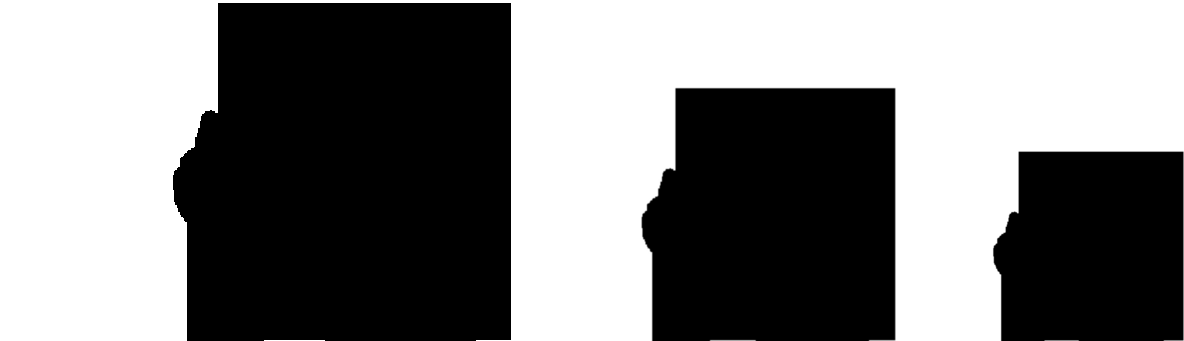

In [678]:
image_oMask = PIL.Image.open("orchid_mask.bmp")
pyramid_oMask = MakeGaussianPyramid(image_oMask, minsize = 190,scale = 0.75)
display(ShowGaussianPyramid(pyramid_oMask))


# 6.

In [650]:
def composeMaskLaplacian(masks, lPyramidA, lPyramidB):
    ret = []
    for i in range(len(lPyramidA)):
        arrA = np.asarray(lPyramidA[i])
        arrB = np.asarray(lPyramidB[i])
        b1, g1, r1  = arrA[:, :, 0], arrA[:, :, 1], arrA[:, :, 2]
        b2, g2, r2  = arrB[:, :, 0], arrB[:, :, 1], arrB[:, :, 2]
        ms = np.asarray(masks[i])
        b1_2 = np.multiply(b1, ms/255)
        g1_2 = np.multiply(g1, ms/255)
        r1_2 = np.multiply(r1, ms/255)
        b2_2 = np.multiply(b2, (1 - ms/255))
        g2_2 = np.multiply(g2, (1 - ms/255))
        r2_2 = np.multiply(r2, (1 - ms/255))
        
        retb = np.add(b1_2,b2_2)
        retg = np.add(g1_2,g2_2)
        retr = np.add(r1_2,r2_2)
        
        zipped = np.dstack((retb, retg, retr))
        zipped = zipped.astype('uint8')
        retImg = PIL.Image.fromarray(np.clip(zipped, 0, 255))
        
        ret.append(retImg)
        #         ret.append(Image.composite(lPyramidA[i],lPyramidB[i],masks[i]))
# compLaplacian[i] = lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)
    return ret

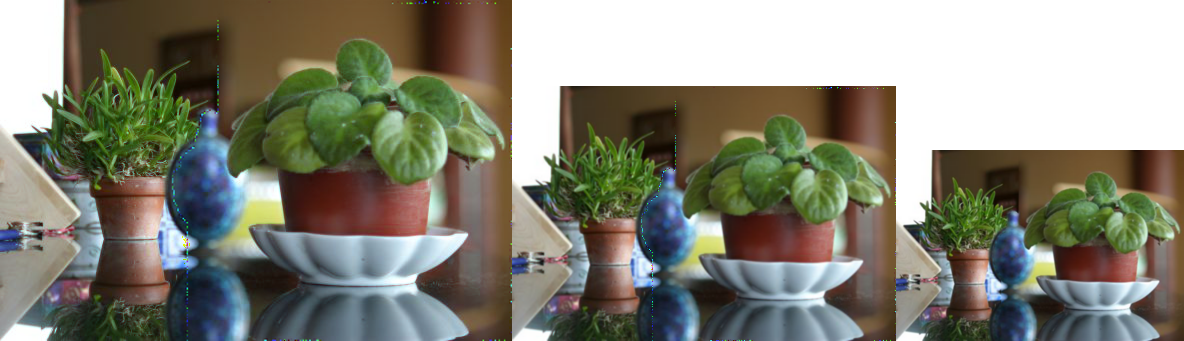

In [681]:
mixed = composeMaskLaplacian(pyramid_oMask, pyramid_orchid, pyramid_violet)

mixedG = ReconstructGaussianFromLaplacianPyramid(mixed)
display(ShowGaussianPyramid(mixedG))

# 7.

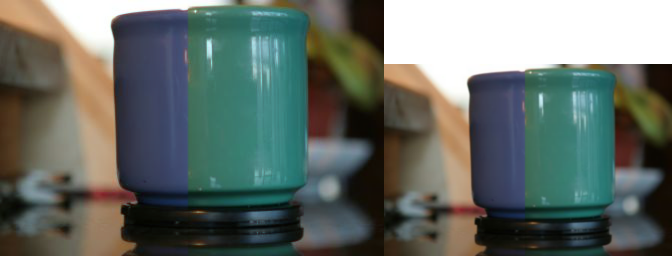

In [665]:
##blue_cup-green_cup 
image_blue= PIL.Image.open("blue_cup.jpg")
image_green = PIL.Image.open("green_cup.jpg")
image_maskC = PIL.Image.open("cup_mask.bmp")
pyramid_blue = MakeLaplacianPyramid(image_blue,minsize = 150) 
pyramid_green = MakeLaplacianPyramid(image_green,minsize = 150) 
pyramid_maskC = MakeGaussianPyramid(image_maskC, minsize = 150,scale = 0.75)

mixed = composeMaskLaplacian(pyramid_maskC, pyramid_blue, pyramid_green)

mixedG = ReconstructGaussianFromLaplacianPyramid(mixed)
display(ShowGaussianPyramid(mixedG))

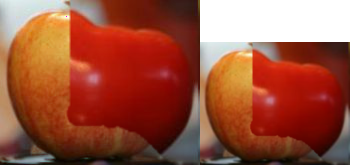

In [669]:
##apple-tomato pairs
image_apple= PIL.Image.open("apple.jpg")
image_tomato = PIL.Image.open("tomato.jpg")
image_maskT = PIL.Image.open("tomato_mask.bmp")
pyramid_apple = MakeLaplacianPyramid(image_apple,minsize = 100) 
pyramid_tomato = MakeLaplacianPyramid(image_tomato,minsize = 100) 
pyramid_maskT = MakeGaussianPyramid(image_maskT, minsize =100,scale = 0.75)

mixed = composeMaskLaplacian(pyramid_maskT, pyramid_apple, pyramid_tomato)

mixedG = ReconstructGaussianFromLaplacianPyramid(mixed)
display(ShowGaussianPyramid(mixedG))